In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
num_samples = 1000
X = np.random.randint(0, 2, size=(num_samples, 12))

Y = np.zeros((num_samples, 2))

# Социальные и экономические группы
social_questions = [0, 3, 5, 7, 11]
economic_questions = [1, 2, 4, 6, 8, 9, 10]

for i in range(num_samples):
    social_score = np.sum(X[i, social_questions])
    economic_score = np.sum(X[i, economic_questions])
    
    # Логика: если соц.балл > 3 и экон.балл < 4 → оппозиция
    if social_score > 3 and economic_score < 4:
        Y[i, 1] = 1  # оппозиция
    else:
        Y[i, 0] = 1  # правящая партия
    
    # Добавляем шум (10% шанс ошибки)
    if np.random.rand() < 0.1:
        Y[i] = Y[i][::-1]  # меняем местами метку
        

# Сохраняем в файлы
np.savetxt('dataIn.txt', X.T, fmt='%d')
np.savetxt('dataOut.txt', Y.T, fmt='%d')


In [7]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros((1, output_size))
    
    def logsig(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
    
    def logsig_derivative(self, x):
        sig = self.logsig(x)
        return sig * (1 - sig)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.logsig(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2
    
    def backward(self, X, y, learning_rate=0.1):
        m = X.shape[0]
        dz2 = self.a2 - y
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        dz1 = np.dot(dz2, self.W2.T) * self.logsig_derivative(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    def compute_loss(self, y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))
    
    def train(self, X, y, epochs=1000, learning_rate=0.1, verbose=True):
        losses = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y, y_pred)
            losses.append(loss)
            self.backward(X, y, learning_rate)
            if verbose and epoch % 100 == 0:
                accuracy = self.accuracy(X, y)
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        return losses
    
    def predict(self, X):
        return self.forward(X)
    
    def accuracy(self, X, y):
        predictions = self.predict(X)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y, axis=1)
        return np.mean(predicted_classes == true_classes)


Начало обучения...
Epoch 0, Loss: 0.7379, Accuracy: 0.8313
Epoch 100, Loss: 0.4417, Accuracy: 0.8313
Epoch 200, Loss: 0.4122, Accuracy: 0.8313
Epoch 300, Loss: 0.3878, Accuracy: 0.8313
Epoch 400, Loss: 0.3803, Accuracy: 0.8438
Epoch 500, Loss: 0.3782, Accuracy: 0.8588
Epoch 600, Loss: 0.3771, Accuracy: 0.8612
Epoch 700, Loss: 0.3760, Accuracy: 0.8600
Epoch 800, Loss: 0.3750, Accuracy: 0.8600
Epoch 900, Loss: 0.3739, Accuracy: 0.8625

Финальные результаты:
Точность на тренировочной выборке: 0.8625
Точность на тестовой выборке: 0.8550


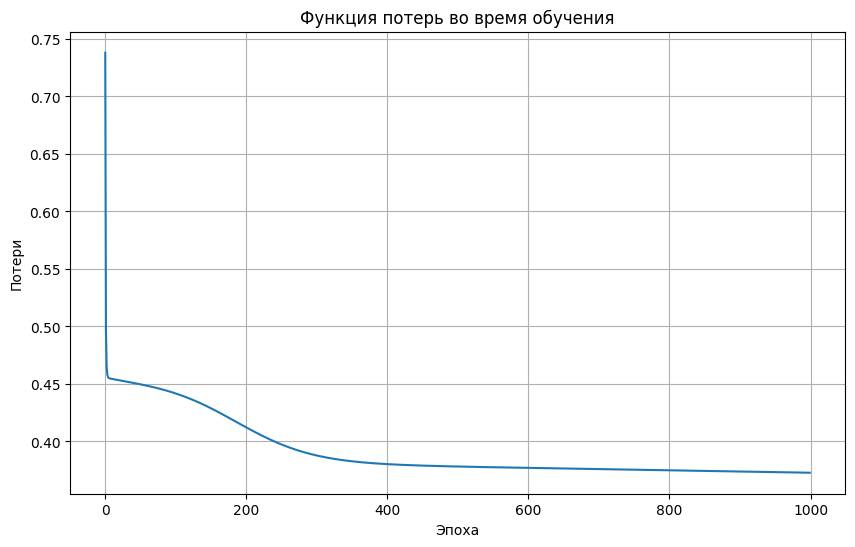


Пример предсказания для новых данных:
Ответы избирателя: [1 0 0 0 1 0 0 0 1 1 1 0]
Предсказание: Правящая партия (уверенность: 0.9739)

Пример предсказания для новых данных:
Ответы избирателя: [0 1 0 0 1 0 1 0 0 0 0 0]
Предсказание: Правящая партия (уверенность: 0.9709)

Пример предсказания для новых данных:
Ответы избирателя: [1 0 1 1 1 1 0 0 1 0 0 0]
Предсказание: Правящая партия (уверенность: 0.8439)


In [9]:
# Загрузка данных
X = np.loadtxt("dataIn.txt").T
Y = np.loadtxt("dataOut.txt").T

# Разделение на train/test
split_idx = int(0.8 * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

    # Создание и обучение модели
model = MLP(input_size=12, hidden_size=8, output_size=2)
    
print("Начало обучения...")
losses = model.train(X_train, Y_train, epochs=1000, learning_rate=0.5)
    
    # Оценка модели
train_accuracy = model.accuracy(X_train, Y_train)
test_accuracy = model.accuracy(X_test, Y_test)
    
print(f"\nФинальные результаты:")
print(f"Точность на тренировочной выборке: {train_accuracy:.4f}")
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")
    
    # Визуализация потерь
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Функция потерь во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.grid(True)
plt.show()
    
    # Пример предсказания
print("\nПример предсказания для новых данных:")
new_voter = np.random.randint(0, 2, size=(1, 12))
prediction = model.predict(new_voter)
party = "Правящая партия" if np.argmax(prediction) == 0 else "Оппозиция"
confidence = np.max(prediction)
    
print(f"Ответы избирателя: {new_voter[0]}")
print(f"Предсказание: {party} (уверенность: {confidence:.4f})")

print("\nПример предсказания для новых данных:")
new_voter = np.random.randint(0, 2, size=(1, 12))
prediction = model.predict(new_voter)
party = "Правящая партия" if np.argmax(prediction) == 0 else "Оппозиция"
confidence = np.max(prediction)
    
print(f"Ответы избирателя: {new_voter[0]}")
print(f"Предсказание: {party} (уверенность: {confidence:.4f})")

print("\nПример предсказания для новых данных:")
new_voter = np.random.randint(0, 2, size=(1, 12))
prediction = model.predict(new_voter)
party = "Правящая партия" if np.argmax(prediction) == 0 else "Оппозиция"
confidence = np.max(prediction)
    
print(f"Ответы избирателя: {new_voter[0]}")
print(f"Предсказание: {party} (уверенность: {confidence:.4f})")